# Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Feature extraction
from sklearn.feature_selection import VarianceThreshold

from boruta import BorutaPy
from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [5]:
data_path = "../../data/"

# Data

## Original

In [6]:
df_radiomics = pd.read_excel(data_path + 'quantitative_radiomic_features.xls')
df_radiomics['Lesion Name'] = df_radiomics['Lesion Name'].str.replace(r'-1\.les|-S2-1\.les', '', regex=True)

target_class = pd.read_csv(data_path + 'target_class.csv')
target_class.rename(columns={'CLID': 'Lesion Name'}, inplace=True)

In [7]:
df = pd.merge(df_radiomics, target_class, on='Lesion Name', how='inner')
df = df.drop(columns=df.columns[0])
df

Maximum enhancement (K1)  Time to peak (K2)  Uptake rate (K3)  \
0                   1.602573            145.433          0.011019   
1                   4.072152            144.752          0.028132   
2                   1.303264            168.383          0.007740   
3                   0.758630             60.000          0.012644   
4                   3.353556             60.000          0.055893   
..                       ...                ...               ...   
71                  1.277688             60.000          0.021295   
72                  1.495674             60.000          0.024928   
73                  2.182750             60.000          0.036379   
74                  1.354828            192.786          0.007028   
75                  1.825341            201.786          0.009046   

    Washout rate (K4)  Curve shape index (K5)   E1 (K6)  \
0            0.000809               -0.099998  1.550204   
1            0.001510               -0.007311  3.973258   
2            0.000667               -0.146959  1.273733   
3            0.000479               -0.150482  0.758630   
4            0.000920               -0.080066  3.353556   
..                ...                     ...       ...   
71           0.000611               -0.149392  1.277688   
72           0.000093               -0.017541  1.495674   
73           0.001081               -0.125678  2.182750   
74           0.000067                0.043301  1.290058   
75           0.001355               -0.057510  1.732952   

    Signal Enhancement Ratio (SER) (K7)  Maximum enhancement-variance (E1)  \
0                              1.111109                           0.125963   
1                              1.007365                           4.054312   
2                              1.172277                           0.534411   
3                              1.177138                           0.037956   
4                              1.087034                           2.330160   
..                                  ...                                ...   
71                             1.175629                           0.271695   
72                             1.017854                           0.123041   
73                             1.143744                           0.225339   
74                             0.958496                           0.108778   
75                             1.061019                          10.346100   

    Enhancement-Variance Time to Peak (E2)  \
0                                   60.000   
1                                  229.504   
2                                   60.000   
3                                  298.418   
4                                   60.000   
..                                     ...   
71                                  60.000   
72                                  60.000   
73                                 313.733   
74                                  60.000   
75                                 343.572   

    Enhancement-variance Increasing Rate (E3)  ...  Margin Sharpness (M1)  \
0                                    0.002099  ...               0.188643   
1                                    0.017666  ...               0.266607   
2                                    0.008907  ...               0.269997   
3                                    0.000127  ...               0.179068   
4                                    0.038836  ...               0.314553   
..                                        ...  ...                    ...   
71                                   0.004528  ...               0.235470   
72                                   0.002051  ...               0.218222   
73                                   0.000718  ...               0.195256   
74                                   0.001813  ...               0.211480   
75                                   0.030113  ...               0.330536   

    Variance of Margin Sharpness (M2)  \
0         

In [8]:
from sklearn.preprocessing import StandardScaler

radiomic_features = df.drop(columns=["Pam50.Call"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(radiomic_features)

df_scaled = pd.DataFrame(scaled_features, columns=radiomic_features.columns)

df_scaled["Pam50.Call"] = df["Pam50.Call"].values

df = df_scaled

In [9]:
df

Maximum enhancement (K1)  Time to peak (K2)  Uptake rate (K3)  \
0                  -0.195663           0.011278         -0.496149   
1                   2.618630           0.003479          0.917726   
2                  -0.536750           0.274115         -0.767103   
3                  -1.157407          -0.967149         -0.361928   
4                   1.799730          -0.967149          3.211365   
..                       ...                ...               ...   
71                 -0.565896          -0.967149          0.352830   
72                 -0.317483          -0.967149          0.653004   
73                  0.465498          -0.967149          1.599129   
74                 -0.477989           0.553592         -0.825950   
75                  0.058200           0.656665         -0.659195   

    Washout rate (K4)  Curve shape index (K5)   E1 (K6)  \
0           -0.151982               -0.297797 -0.155749   
1            0.397861                0.255429  2.655287   
2           -0.263946               -0.578093 -0.476489   
3           -0.411282               -0.599120 -1.074071   
4           -0.065331               -0.178825  1.936358   
..                ...                     ...       ...   
71          -0.307554               -0.592611 -0.471901   
72          -0.714435                0.194371 -0.219010   
73           0.061532               -0.451073  0.578081   
74          -0.734472                0.557517 -0.457550   
75           0.276111               -0.044192  0.056261   

    Signal Enhancement Ratio (SER) (K7)  Maximum enhancement-variance (E1)  \
0                              0.009570                          -0.130554   
1                             -0.257523                          -0.074160   
2                              0.167049                          -0.124690   
3                              0.179564                          -0.131817   
4                             -0.052412                          -0.098911   
..                                  ...                                ...   
71                             0.175679                          -0.128462   
72                            -0.230518                          -0.130596   
73                             0.093590                          -0.129127   
74                            -0.383337                          -0.130801   
75                            -0.119389                           0.016163   

    Enhancement-Variance Time to Peak (E2)  \
0                                -1.065664   
1                                 0.222799   
2                                -1.065664   
3                                 0.746640   
4                                -1.065664   
..                                     ...   
71                               -1.065664   
72                               -1.065664   
73                                0.863055   
74                               -1.065664   
75                                1.089872   

    Enhancement-variance Increasing Rate (E3)  ...  Margin Sharpness (M1)  \
0                                   -0.123696  ...              -0.510705   
1                                   -0.093276  ...               1.183825   
2                                   -0.110393  ...               1.257501   
3                                   -0.127551  ...              -0.718824   
4                                   -0.051902  ...               2.225907   
..                                        ...  ...                    ...   
71                                  -0.118950  ...               0.507069   
72                                  -0.123792  ...               0.132186   
73                                  -0.126395  ...              -0.366977   
74                                  -0.124256  ...              -0.014350   
75                                  -0.068949  ...               2.573298   

    Variance of Margin Sharpness (M2)  \
0         

## SMOTE

In [10]:
features = df.columns.difference(['Pam50.Call'])
target_col = 'Pam50.Call'

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target_col],
    test_size=0.2,
    random_state=42,
    stratify=df[target_col]
)

In [11]:
under_sampler = RandomUnderSampler(sampling_strategy={"LumA": 30}, random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy="not majority", random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_under, y_train_under)

print("\nDistribución tras Under-Sampling + Over-Sampling en train:")
print(y_train_resampled.value_counts())


Distribución tras Under-Sampling + Over-Sampling en train:
Pam50.Call
Basal    30
Her2     30
LumA     30
LumB     30
Name: count, dtype: int64


In [12]:
df_resampled = pd.concat(
    [pd.DataFrame(X_train_resampled), pd.Series(y_train_resampled, name='Pam50.Call')],
    axis=1
)

In [13]:
df_train = df_resampled

# Feature extraction

## Functions

In [14]:
def apply_variance_threshold(df, target_col, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    df_features = selector.fit_transform(df.drop(columns=[target_col]))
    selected_columns = df.drop(columns=[target_col]).columns[selector.get_support()]
    
    return df_features, selected_columns

In [15]:
def apply_boruta(df_features, target, selected_columns, model_name="RandomForest", n_estimators=100, random_state=42):
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=n_estimators, random_state=random_state),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=n_estimators, random_state=random_state),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=n_estimators, random_state=random_state),
    }
    
    if model_name not in models:
        raise ValueError(
            f"Model '{model_name}' is not supported by Boruta. "
        )
    
    model = models[model_name]
    
    boruta_selector = BorutaPy(model, n_estimators='auto', random_state=random_state)
    boruta_selector.fit(df_features, df_train[target])
    selected_features = selected_columns[boruta_selector.support_]
    
    return selected_features

In [16]:
def cluster_and_select_representative_features(correlation_matrix, num_clusters):
    distance_matrix = 1 - np.abs(correlation_matrix)
    linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')
    
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    cluster_df = pd.DataFrame({
        "Feature": correlation_matrix.columns,
        "Cluster": clusters
    })
    
    representative_features = []
    for cluster_id in cluster_df["Cluster"].unique():
        cluster_features = cluster_df.loc[cluster_df["Cluster"] == cluster_id, "Feature"].values
        cluster_corr = correlation_matrix.loc[cluster_features, cluster_features].mean(axis=1)
        representative = cluster_corr.idxmax()
        representative_features.append(representative)
    
    return representative_features

## Procedure

In [17]:
df_features, selected_columns_after_variance = apply_variance_threshold(df_train, "Pam50.Call")

In [18]:
print(f"Number of features retained after applying variance threshold: {len(selected_columns_after_variance)}")
print(f"Selected features: {selected_columns_after_variance}")

Number of features retained after applying variance threshold: 36
Selected features: Index(['Contrast (T1)', 'Correlation (T2)', 'Curve shape index (K5)',
       'Difference Entropy (T3)', 'Difference Variance (T4)', 'E1 (K6)',
       'Effective Diameter (S2)', 'Energy (T5)',
       'Enhancement-Variance Time to Peak (E2)',
       'Enhancement-variance Decreasing Rate (E4)',
       'Enhancement-variance Increasing Rate (E3)', 'Entropy (T6)',
       'Homogeneity (T7)', 'IMC1 (T8)', 'IMC2 (T9)', 'Irregularity (G2)',
       'Margin Sharpness (M1)', 'Maximum Correlation Coefficient (T10)',
       'Maximum Diameter (S5)', 'Maximum enhancement (K1)',
       'Maximum enhancement-variance (E1)',
       'Signal Enhancement Ratio (SER) (K7)', 'Size/Lesion volume (S1)',
       'Sphericity (G1)', 'Sum Average (T11)', 'Sum Entropy (T12)',
       'Sum Variance (T13)', 'Surface Area (S3)',
       'Surface Area to Volume ratio (G3)', 'Time to peak (K2)',
       'Uptake rate (K3)', 'Variance (T14)',
  

In [19]:
selected_features = apply_boruta(df_features, "Pam50.Call", selected_columns_after_variance, model_name="GradientBoosting")
print(f"Number of features retained after applying Boruta: {len(selected_features)}")
print(f"Selected features: {selected_features}")

Number of features retained after applying Boruta: 11
Selected features: Index(['Energy (T5)', 'Enhancement-variance Decreasing Rate (E4)',
       'Enhancement-variance Increasing Rate (E3)', 'Margin Sharpness (M1)',
       'Maximum Diameter (S5)', 'Maximum enhancement-variance (E1)',
       'Sphericity (G1)', 'Sum Average (T11)', 'Surface Area (S3)',
       'Variance of Radial Gradient Histogram (vRGH) (M3)',
       'Washout rate (K4)'],
      dtype='object')


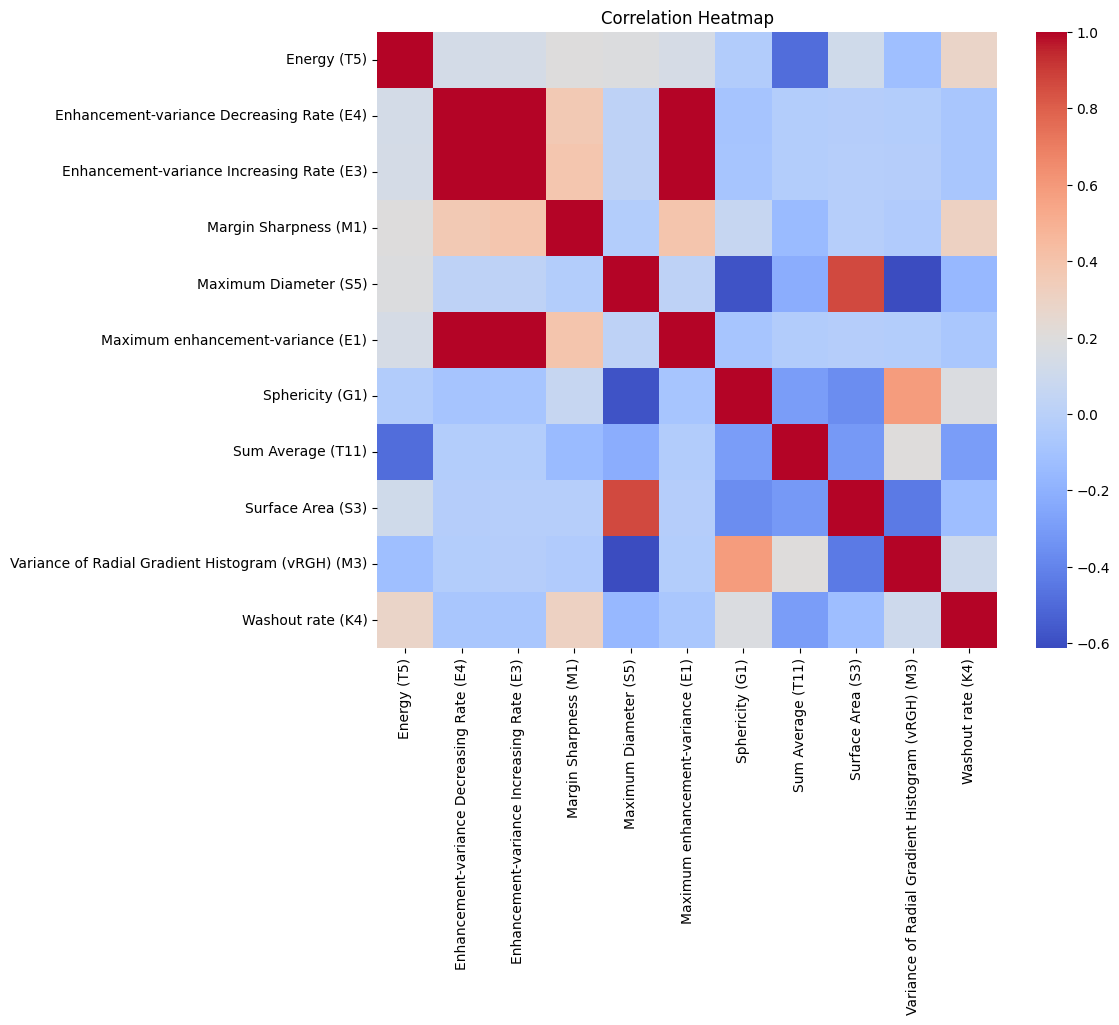

In [20]:
correlation_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig('correlation_heatmat.png', dpi=300, bbox_inches='tight')  # Línea opcional para guardar el plot
plt.show()

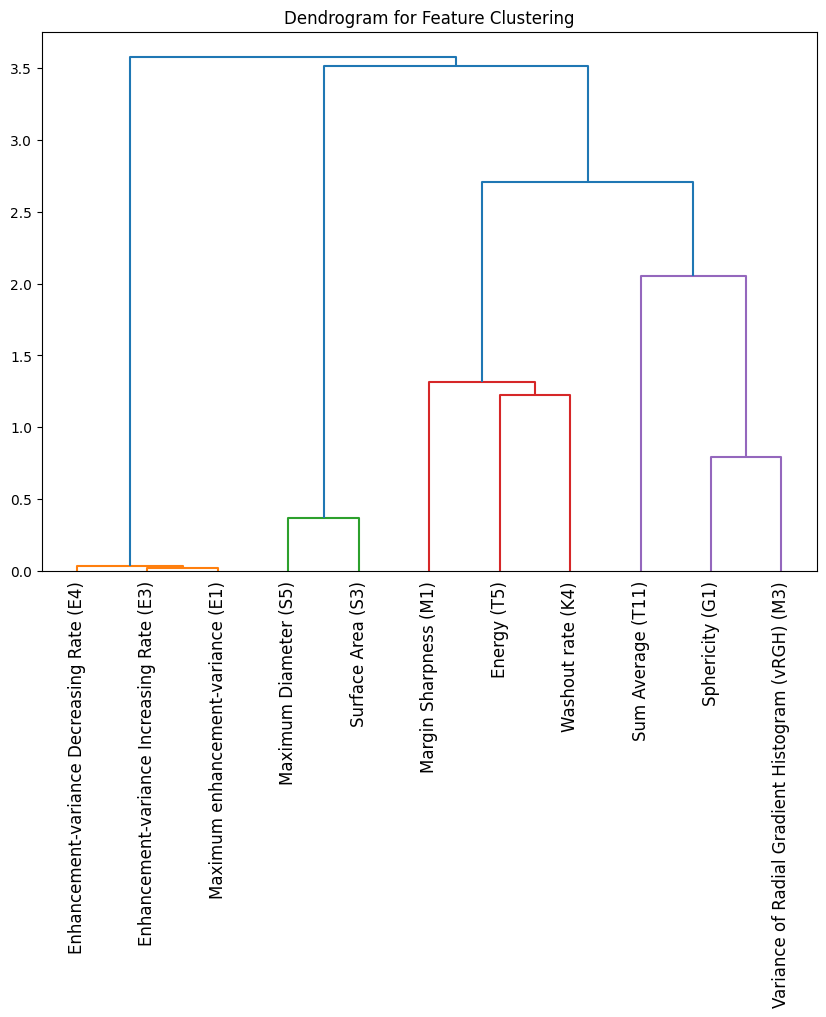

In [21]:
linkage_matrix = linkage(correlation_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=selected_features, leaf_rotation=90)
plt.title("Dendrogram for Feature Clustering")
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')  # Línea opcional para guardar el plot
plt.show()

In [ ]:
representative_features = cluster_and_select_representative_features(
    correlation_matrix=correlation_matrix,
    num_clusters=3
)

In [ ]:
print(f"Number of representative features: {len(representative_features)}")
print(f"Representative features selected from clusters: {representative_features}")

# Train

In [ ]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, features, target_col, model, imprimir=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    return macro_f1

In [ ]:
X_train_resampled_selected = X_train_resampled[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    X_train_resampled_selected, X_test_selected, y_train_resampled, y_test,
    features=[col for col in df.columns if col != "Pam50.Call"],
    target_col="Pam50.Call",
    model=rf_model,
    imprimir=True
)